In [1]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as pp
import numpy as np
import csv
import os

from matplotlib import cm
from numpy import arctan, log, pi, sqrt

%matplotlib notebook

# os.chdir("D:\Engineering\Python\FHD")


In [2]:
#Making grid

nx  = 50
ny  = 50
nt  = 100

xmin = 0
xmax = 10
ymin = 0
ymax = 10

dx = (xmax - xmin) / (nx - 1)
dy = (ymax - ymin) / (ny - 1)
dt = 0.01

x  = np.linspace(xmin, xmax, nx)
y  = np.linspace(xmin, xmax, ny)

X, Y = np.meshgrid(x, y)

L = ymax

In [3]:
u  = np.zeros((nx, ny))
un = np.zeros((nx, ny))

v  = np.zeros((nx, ny))
vn = np.zeros((nx, ny))

T  = np.zeros((nx, ny))
Tn = np.zeros((nx, ny))

C  = np.zeros((nx, ny))
Cn = np.zeros((nx, ny))

In [4]:
#Problem specs

a = 1

beta = 0.499 #unsteadiness paramepter

nu = 0.000829

rho = 997.5

mu0 = 4e-7*pi

M = 8.6e5

h = 12.5e-6   #height of magnet

w = 25e-6     #width of magnet

c = 4178      #spcefic heat   Cp

Cv = 4.15

eps = 0.2

tau = c/Cv

Q0 = 50 #heat generation

mu = 0.001


#Boundary Condition

V0 = -5

#Tf = 250

Cf = 0.2/100
Cinf = 0.4/100

Tinf = 333
T_init = 293 #initial Temp.

delT = Tinf - T_init

kf = 0.6129
kp = 80.4

alpha = kf/(rho*c)  #thermal diffusity

Pr = nu/alpha

Re = V0*L/nu

gamma2 = 0.2

Nu = 0.05928 * ((0.44 + Cf)**0.536) * Re**0.7 * Pr**0.4

hf = kf*Nu/L

In [5]:
kB = 1.385e-23
dp = 1e-8
TF = (Tinf + T_init)/2 #Film temperature
DB = (kB*TF)/(3 * pi * mu * dp)

In [6]:
DT = (mu/rho) * (0.26 * kf/(kf + kp))

In [7]:
hm = gamma2 * DB * sqrt(alpha/nu)

In [8]:
def Hcalc(M, i, j, h, w):
    H = M**2*(-4*h*((4*h**2*(w - i)**2 + (-h**2 + j**2 + (w - i)**2)**2)*(-h**2 + j**2 - (w + i)**2) + (4*h**2*(w + i)**2 + (-h**2 + j**2 + (w + i)**2)**2)*(h**2 - j**2 + (w - i)**2))*((-h + j)**2 + (-w + i)**2)*((-h + j)**2 + (w + i)**2)*((h + j)**2 + (-w + i)**2)*((h + j)**2 + (w + i)**2)*(arctan(2*h*(-w + i)/(-h**2 + j**2 + (-w + i)**2)) - arctan(2*h*(w + i)/(-h**2 + j**2 + (w + i)**2))) + (4*h**2*(w - i)**2 + (-h**2 + j**2 + (w - i)**2)**2)*(4*h**2*(w + i)**2 + (-h**2 + j**2 + (w + i)**2)**2)*(-(w + i)*(-(-h + j)**2 + (h + j)**2)*((-h + j)**2 + (-w + i)**2)*((h + j)**2 + (-w + i)**2) + ((-w + i)*((h + j)**2 + (-w + i)**2) + (w - i)*((-h + j)**2 + (-w + i)**2))*((-h + j)**2 + (w + i)**2)*((h + j)**2 + (w + i)**2))*(log(((-h + j)**2 + (-w + i)**2)/((h + j)**2 + (-w + i)**2)) - log(((-h + j)**2 + (w + i)**2)/((h + j)**2 + (w + i)**2))))/(2*pi*sqrt(M**2*((log(((h - j)**2 + (w - i)**2)/((h + j)**2 + (w - i)**2)) - log(((h - j)**2 + (w + i)**2)/((h + j)**2 + (w + i)**2)))**2 + 4*(arctan(2*h*(w - i)/(-h**2 + j**2 + (w - i)**2)) + arctan(2*h*(w + i)/(-h**2 + j**2 + (w + i)**2)))**2))*(4*h**2*(w - i)**2 + (-h**2 + j**2 + (w - i)**2)**2)*(4*h**2*(w + i)**2 + (-h**2 + j**2 + (w + i)**2)**2)*((-h + j)**2 + (-w + i)**2)*((-h + j)**2 + (w + i)**2)*((h + j)**2 + (-w + i)**2)*((h + j)**2 + (w + i)**2))
    return H

In [9]:
#Boundary conditions #1

T[:, 1] = -((hf*dy)/kf) * (T_init - T[:, 0]) + T[:, 0]
C[:, 1] = -((hm*dy)/DB) * (Cf - C[:, 0]) + C[:, 0]
T[:, ny-1] = Tinf
C[:, ny-1] = Cinf
v[:, ny-1] = 0

c:\users\light\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
#Boundary conditions #2

for n in range(nt):
    for i in range(nx):
        u[i, ny-1] = (a*i)/(1-beta*n)
        u[i, 0]    = (a*i)/ (1-(beta*n))
        v[i, 0]    = (-V0)/(1-(beta*n)**(0.5))

In [11]:
def diff1(i, j, F, d, var): #derivative 1
    if (var == "x"):
        dF = (F[i+1, j] - F[i, j])/d
    elif (var == "y"):
        dF = (F[i, j+1] - F[i, j])/d
    return dF

In [12]:
def diff2(i, j, F, d, var): #derivative 2
    if (var == "x"):
        d2F = (F[i+1, j] - 2*F[i, j] + F[i-1, j])/(2*d)
    elif (var == "y"):
        d2F = (F[i, j+1] - 2*F[i, j] + F[i, j-1])/(2*d)
    return d2F

In [ ]:
u
v.fill(V0)
T.fill(Tini)
C

In [13]:
#Iteration

udiff = 1
Tdiff = 1
Cdiff = 1
stepcount = 0
accu = 0.001

udiffDat = []
TdiffDat = []
CdiffDat = []


while (udiff > accu) and (Tdiff > accu) and (Cdiff > accu):
    un = u.copy()
    vn = v.copy()
    Tn = T.copy()
    Cn = C.copy()

    for n in range(nt):
        for i in range(nx-2):
            for j in range(1, ny-2):
                #Velocity
                u[i, j] = dt * (((a*i*(a+beta))/(1-beta*n)**2) + (
                                nu * diff2(i, j, un, dy, "y") +
                                mu0*M/rho * Hcalc(M, i, j, h, w) - 
                                (un[i, j] * diff1(i, j, un, dx, "x") +
                                 vn[i, j] * diff1(i, j, un, dy, "y")))) + un[i, j]

                #Temperature
                T[i, j] = dt * (alpha * diff2(i, j, Tn, dy, "y") + (
                                tau * (DB * diff1(i, j, Cn, dy, "y") * diff1(i, j, Tn, dy, "y") + 
                                (DT/Tinf) * (diff1(i, j, Tn, dy, "y")**2)) + 
                                (Q0/(rho*c)) * (Tn[i, j] - Tinf) - 
                                un[i, j] * diff1(i, j, Tn, dx, "x") +
                                vn[i, j] * diff1(i, j, Tn, dy, "y"))) + Tn[i, j]

                #Concentration
                C[i, j] = dt * (DB * diff2(i, j, Cn, dy, "y") + (
                                (DT/Tinf) * diff2(i, j, Tn, dy, "y") -
                                (un[i, j] * diff1(i, j, Cn, dx, "x") + 
                                 vn[i, j] * diff1(i, j, Cn, dy, "y")))) + Cn[i, j]




                udiff = (np.sum(u) - np.sum(un))/np.sum(u)
                Tdiff = (np.sum(T) - np.sum(Tn))/np.sum(T)
                Cdiff = (np.sum(C) - np.sum(Cn))/np.sum(C)

                #print("udiff = " + str(udiff), "; Tdiff = " + str(Tdiff), " Cdiff = " + str(Cdiff))

                stepcount += 1

                
                udiffDat.append(udiff)
                TdiffDat.append(Tdiff)
                CdiffDat.append(Cdiff)



                if (udiff > 0) or (Tdiff > 0) or (Cdiff > 0):
                    break

<IPython.core.display.Javascript object>


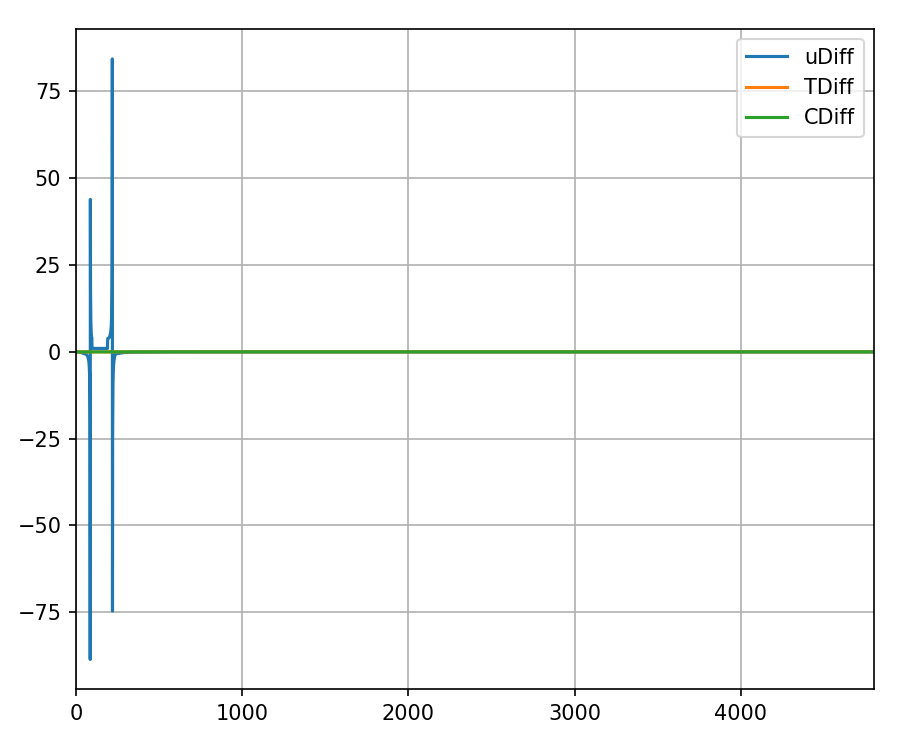

In [14]:
%matplotlib notebook

xu = np.linspace(0, stepcount, stepcount)

pp.figure()

pp.autoscale(enable=True, axis='x', tight=True)

pp.plot(xu, udiffDat, label = "uDiff")
pp.plot(xu, TdiffDat, label = "TDiff")
pp.plot(xu, CdiffDat, label = "CDiff")

pp.grid(True)
pp.legend();

pp.tight_layout()
fig = pp.gcf()
fig.set_size_inches(6, 5)

<IPython.core.display.Javascript object>


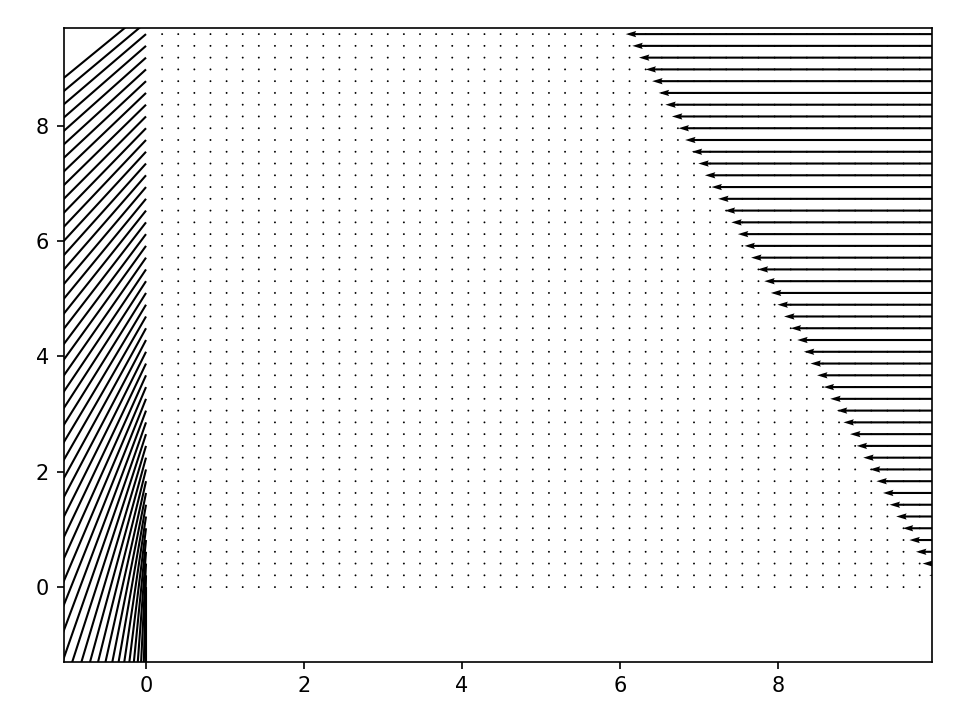

In [15]:
pp.figure()
pp.quiver(X, Y, u, v);
pp.tight_layout()

<IPython.core.display.Javascript object>


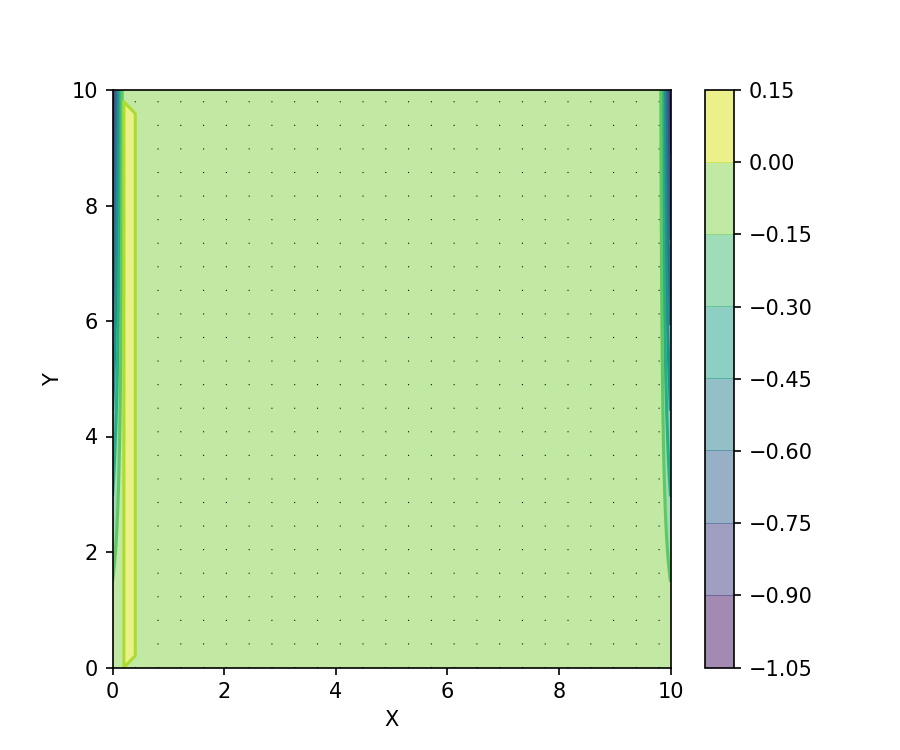

In [16]:
fig = pp.figure()
# plotting the pressure field as a contour
pp.contourf(X, Y, u, alpha=0.5, cmap=cm.viridis)  
pp.colorbar()
# plotting the pressure field outlines
pp.contour(X, Y, u, cmap=cm.viridis)  
# plotting velocity field
pp.quiver(X[::2, ::2], Y[::2, ::2], u[::2, ::2], v[::2, ::2]) 
pp.xlabel('X')
pp.ylabel('Y');

fig = pp.gcf()
fig.set_size_inches(6, 5)

In [17]:
un[1,:]

array([-0.02066073,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.02066073])